# Load Data

Swiss temperature data: 27 stations, 12 months, training set: 1965-1989, test set: 1990-2014

In [1]:
# Load swiss temperature data

import pandas as pd
import glob

path = "data/swiss"
filenames = glob.glob(path + "/*.txt")
dfs = []
N = len(filenames)
for filename in filenames:
    with open(filename, encoding="Windows-1252") as f:
        content = f.readlines()
        station = content[5].split(None, 1)[1][:-1]
        altitude = float(content[6].split()[3])
        latitude = int(content[7].split()[1][:-1]) + float(content[7].split()[2][:-1]) / 60
        longitude = int(content[7].split()[5][:-1]) + float(content[7].split()[6][:-1]) / 60
    df = pd.read_table(
        filename,
        encoding="Windows-1252",
        delim_whitespace=True,
        skiprows=27,
    )
    df["Station"] = station
    df["Altitude"] = altitude
    df["Latitude"] = latitude
    df["Longitude"] = longitude
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
df_all.head()


Year  Month  Temperature  Precipitation  Station  Altitude   Latitude  \
0  1864      1         -4.5           40.8  Altdorf     438.0  46.886667   
1  1864      2         -0.4           38.0  Altdorf     438.0  46.886667   
2  1864      3          5.4           31.6  Altdorf     438.0  46.886667   
3  1864      4          7.2          155.1  Altdorf     438.0  46.886667   
4  1864      5         12.6          103.9  Altdorf     438.0  46.886667   

   Longitude  
0   8.621667  
1   8.621667  
2   8.621667  
3   8.621667  
4   8.621667

C:\Users\Xiaoyang Ma\AppData\Local\Temp\ipykernel_26324\3236880904.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_1965_1989_january = data_1965_1989[df_all["Month"] == 1].groupby("Station")
C:\Users\Xiaoyang Ma\AppData\Local\Temp\ipykernel_26324\3236880904.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_1965_1989_july = data_1965_1989[df_all["Month"] == 7].groupby("Station")


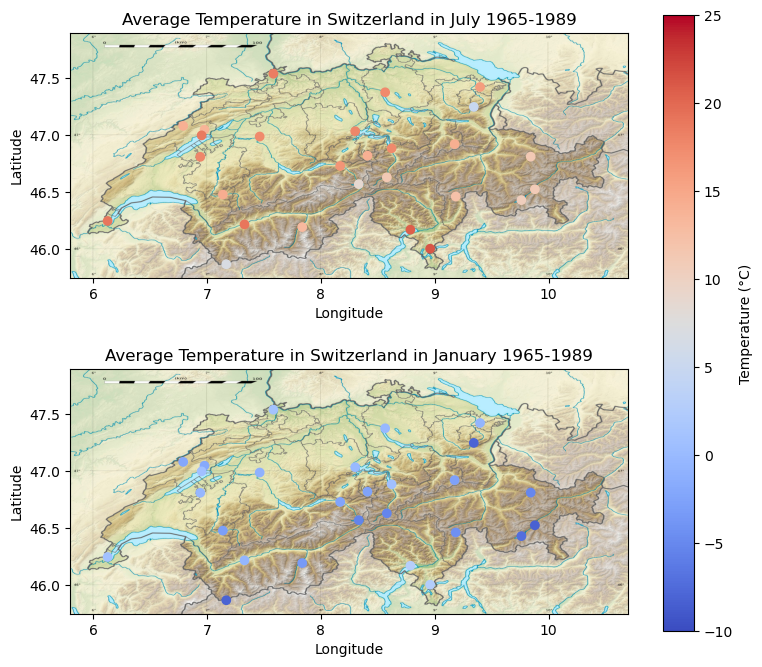

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

data_1965_1989 = df_all[(df_all["Year"] >= 1965) & (df_all["Year"] < 1990)]
data_1965_1989_january = data_1965_1989[df_all["Month"] == 1].groupby("Station")
data_1965_1989_july = data_1965_1989[df_all["Month"] == 7].groupby("Station")

img = plt.imread("data/swiss/Switzerland_relief_location_map.jpg")
plt.figure(figsize=(9, 8))
ax1 = plt.subplot(2, 1, 1)
ax1.imshow(img, zorder=0, extent=[5.8, 10.7, 45.75, 47.9])
ax1.scatter(data_1965_1989_july.mean()["Longitude"], data_1965_1989_july.mean()["Latitude"], c=data_1965_1989_july.mean()["Temperature"], cmap="coolwarm", vmin=-10, vmax=25)
ax1.set_title("Average Temperature in Switzerland in July 1965-1989")
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")

ax2 = plt.subplot(2, 1, 2)
ax2.imshow(img, zorder=0, extent=[5.8, 10.7, 45.75, 47.9])
im = ax2.scatter(data_1965_1989_january.mean()["Longitude"], data_1965_1989_january.mean()["Latitude"], c=data_1965_1989_january.mean()["Temperature"], cmap="coolwarm", vmin=-10, vmax=25)
cbar = plt.colorbar(im, ax=[ax1, ax2])
cbar.set_label("Temperature (°C)")
ax2.set_title("Average Temperature in Switzerland in January 1965-1989")
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")
plt.show()


# Static Graph Learning

## 1. Node domain, global smoothness

(CVXPY) Dec 13 08:33:20 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')
0
(27, 25)
1
(27, 25)
2
(27, 25)
3
(27, 25)
4
(27, 25)
5
(27, 25)
6
(27, 25)
7
(27, 25)
8
(27, 25)
9
(27, 25)
10
(27, 25)
11
(27, 25)
12
(27, 25)
13
(27, 25)
14
(27, 25)
15
(27, 25)
16
(27, 25)
17
(27, 25)
18
(27, 25)
19
(27, 25)
0
(27, 25)
1
(27, 25)
2
(27, 25)
3
(27, 25)
4
(27, 25)
5
(27, 25)
6
(27, 25)
7
(27, 25)
8
(27, 25)
9
(27, 25)
10
(27, 25)
11
(27, 25)
12
(27, 25)
13
(27, 25)
14
(27, 25)
15
(27, 25)
16
(27, 25)
17
(27, 25)
18
(27, 25)
19
(27, 25)
[[-1.03526143e-01 -7.88005214e-11 -1.61406594e-01  2.20873416e-01
   1.06709565e-09 -1.54899985e-09 -4.47392159e-09 -8.55097178e-11
  -1.55569373e-09 -1.54525757e-09 -2.69626723e-01 -4.96848770e-09
  -1.08387129e-09 -1.53703527e-09  8.60772937e-10  5.15644648e-09
   8.47748732e-02  1.76580967e-01 -1.91995815e-01  1.46817072e-01
  -2.53326800e-09 -1.35120316e-

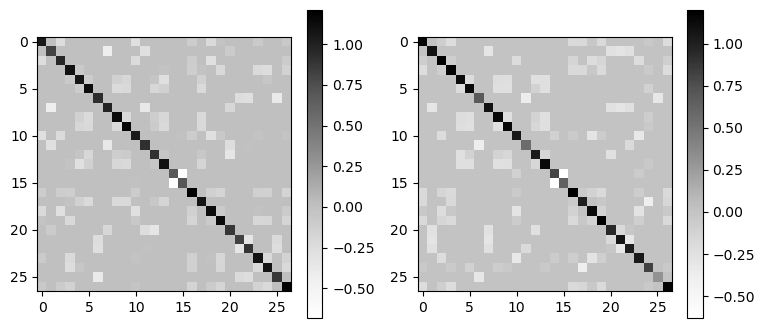

In [3]:
import cvxpy as cp
import numpy as np

def topo_infer_smooth(data, N, alpha, beta, iter, tr=None):
    M = data.shape[1] if data.ndim == 2 else 1
    if M == 1:
        data = data.reshape(-1, 1)
    if tr is None:
        tr = N
    y = cp.Variable((N, M))
    y_0 = data
    Lap = cp.Variable((N, N), PSD=True)

    for cnt in range(iter):
        print(cnt)
        constraints = [Lap @ np.ones((N,)) == np.zeros((N,)), Lap - cp.diag(cp.diag(Lap)) <= 0, cp.trace(Lap) == tr]
        print(y_0.shape)
        objective = cp.Minimize(alpha * cp.trace(cp.quad_form(y_0, Lap)) + beta * cp.norm(Lap, "fro") ** 2)
        prob = cp.Problem(objective, constraints)
        prob.solve()
        Lap_0 = Lap.value
        Lap_0 = Lap_0 - np.eye(N) * np.min(np.linalg.eigvals(Lap_0))
        objective2 = cp.Minimize(cp.norm(y - data, "fro") ** 2 + alpha * cp.sum([cp.quad_form(y[:, i], Lap_0) for i in range(M)]))
        prob2 = cp.Problem(objective2)
        prob2.solve()
        y_0 = y.value
    
    return Lap_0

t_january = np.array(data_1965_1989_january["Temperature"].apply(lambda x: np.array(x.values.tolist())).to_list()) # 27x25
t_july = np.array(data_1965_1989_july["Temperature"].apply(lambda x: np.array(x.values.tolist())).to_list())

alpha = 0.01
beta = 0.5
Lap_0_january = topo_infer_smooth(t_january, N, alpha, beta, 20)
Lap_0_july = topo_infer_smooth(t_july, N, alpha, beta, 20)
print(Lap_0_january - Lap_0_july)

plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.imshow(Lap_0_january, cmap='Greys', interpolation='nearest')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(Lap_0_july, cmap='Greys', interpolation='nearest')
plt.colorbar()
plt.show()


C:\Users\Xiaoyang Ma\AppData\Local\Temp\ipykernel_26324\362669987.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  longitudes = [df_all[df_all.eq(station_name).any(1)]["Longitude"].values[0] for station_name in stations]
C:\Users\Xiaoyang Ma\AppData\Local\Temp\ipykernel_26324\362669987.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  latitudes = [df_all[df_all.eq(station_name).any(1)]["Latitude"].values[0] for station_name in stations]
C:\Users\Xiaoyang Ma\AppData\Local\Temp\ipykernel_26324\362669987.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  altitudes = np.array([df_all[df_all.eq(station_name).any(1)]["Altitude"].values[0] for station_name in stations])


47


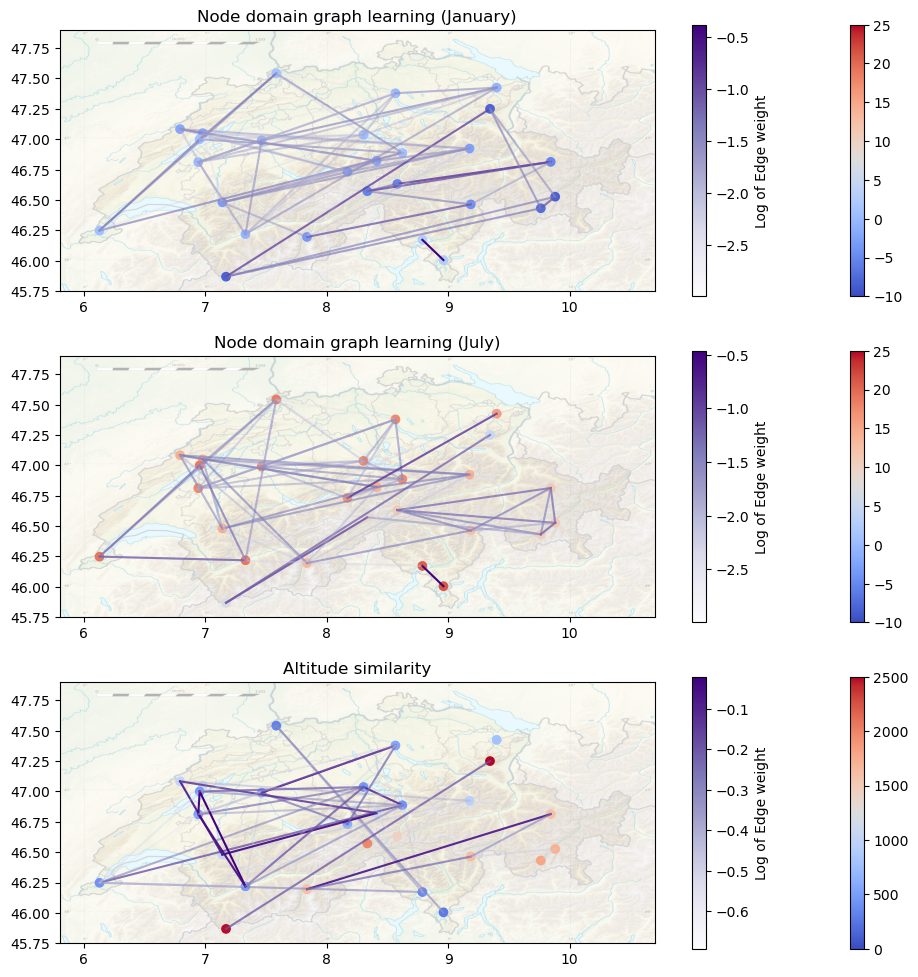

In [4]:
stations = data_1965_1989_january.mean()["Temperature"].keys()
longitudes = [df_all[df_all.eq(station_name).any(1)]["Longitude"].values[0] for station_name in stations]
latitudes = [df_all[df_all.eq(station_name).any(1)]["Latitude"].values[0] for station_name in stations]
altitudes = np.array([df_all[df_all.eq(station_name).any(1)]["Altitude"].values[0] for station_name in stations])

# Lap_0_altitude = topo_infer_smooth(altitudes / 200, N, 0.01, 0.3, 20)
# plt.figure(figsize=(9, 4))
# plt.imshow(Lap_0_altitude, cmap='Greys', interpolation='nearest')
# plt.colorbar()
# plt.show()

Lap_0_altitude = np.zeros((N, N))
cnt = 0
for i in range(N):
    for j in range(i+1, N):
        Lap_0_altitude[i, j] = -np.exp(-np.abs(altitudes[i] - altitudes[j]) / 150)
        Lap_0_altitude[j, i] = Lap_0_altitude[i, j]
        if (Lap_0_altitude[i, j] < -0.5):
            cnt += 1
    Lap_0_altitude[i, i] = -np.sum(Lap_0_altitude[i, :])
print(cnt)

def plot_graph(ax, data, Lap, N, th, img, vmin=-10, vmax=25):
    ax.imshow(img, zorder=0, extent=[5.8, 10.7, 45.75, 47.9], alpha=0.3)
    z = ax.scatter(longitudes, latitudes, c=data, cmap="coolwarm", vmin=vmin, vmax=vmax)
    plt.colorbar(z, ax=ax)

    color_norm = mpl.colors.Normalize(vmin=np.log(th), vmax=np.log(np.max(-Lap)))
    cmap = cm.Purples
    color_map = cm.ScalarMappable(norm=color_norm, cmap=cmap)
    for i in range(N):
        for j in range(i+1, N):
            if Lap[i, j] < -th:
                ax.plot([longitudes[i], longitudes[j]], [latitudes[i], latitudes[j]], c=color_map.to_rgba(np.log(-Lap[i, j])), alpha=color_norm(np.log(-Lap[i, j])))
    cbar = plt.colorbar(color_map)
    cbar.set_label("Log of Edge weight")

plt.figure(figsize=(12, 12))
ax1 = plt.subplot(3, 1, 1)
plot_graph(ax1, data_1965_1989_january.mean()["Temperature"], Lap_0_january, N, 0.05, img)
ax1.set_title("Node domain graph learning (January)")

ax2 = plt.subplot(3, 1, 2)
plot_graph(ax2, data_1965_1989_july.mean()["Temperature"], Lap_0_july, N, 0.05, img)
ax2.set_title("Node domain graph learning (July)")

ax3 = plt.subplot(3, 1, 3)
plot_graph(ax3, altitudes, Lap_0_altitude, N, 0.5, img, vmin=0, vmax=2500)
ax3.set_title("Altitude similarity")

plt.show()

## 2. Graphical Lasso

0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
[0.01229784 0.15176375 0.31622066 0.49068872 0.5462225  0.6224433
 0.62578326 0.68636709 0.74692498 0.82444394 0.86453539 0.87648939
 0.89368178 0.89896127 0.9160733  0.92585228 0.94032647 0.95307253
 1.01425923 1.00967457 0.96584948 1.00370658 0.97266755 0.97777599
 0.98476732 0.99450732 0.99130795]
-38.485485236015236


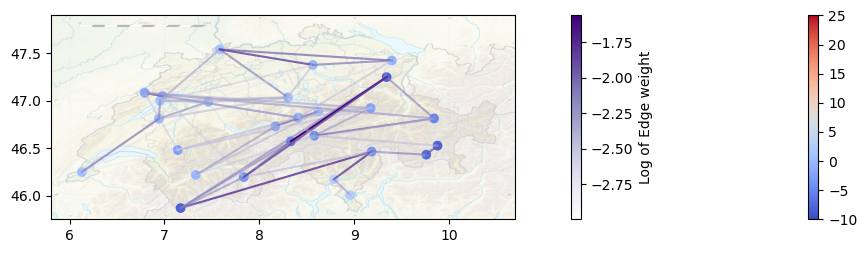

In [5]:
# from sklearn.covariance import graphical_lasso

def soft_threshold(x, l):
    return np.sign(x) * np.maximum(0, np.abs(x) - l)

def topo_infer_glasso(data, N, l, iter=100, tol=1e-4, eps=0):
    M = data.shape[1] if data.ndim == 2 else 1
    if M == 1:
        data = data.reshape(-1, 1)
    # data is N x M
    S = np.cov(data)
    W = S + l * np.eye(N) # Initialize the inverse of precision matrix
    W_new = np.copy(W)
    # print(W)
    Q = np.copy(S) # Initialize the precision matrix

    # tol2 = tol * (np.sum(np.abs(S)) - np.sum(np.abs(np.diag(S)))) / (N - 1)

    for cnt in range(iter):
        print(cnt)
        # Solve for the precision matrix estimate
        for j in range(N):
            index = np.arange(N) != j

            # Solve the modified Lasso problem
            # beta = -Q[:, j] / Q[j, j]
            beta = np.zeros(N)
            beta_new = np.copy(beta)

            for cnt2 in range(iter):
                for k in np.arange(N)[index]:
                    index2 = np.logical_and(np.arange(N) != k, index)
                    beta_new[k] = soft_threshold(S[k, j] - W_new[k, index2] @ beta_new[index2], l) / W_new[k, k]
                if np.linalg.norm(beta_new - beta, ord=1) < tol:
                    break
                beta = np.copy(beta_new)

            # Check the solution
            # beta_var = cp.Variable(N)
            # w, v = np.linalg.eig(W_new[np.ix_(index, index)])
            # W_half = v @ np.diag(np.sqrt(w)) @ v.T
            # W_half_inv = v @ np.diag(1.0 / np.sqrt(w)) @ v.T
            # objective = cp.Minimize(0.5 * cp.sum_squares(W_half @ beta_var[index] - W_half_inv @ S[index, j]) + l * cp.norm(beta_var, 1) + cp.abs(beta_var[j]))
            # prob = cp.Problem(objective)
            # prob.solve()
            # beta2 = beta_var.value
            # print(np.linalg.norm(beta - beta2))

            # Update the inverse of precision matrix
            W_new[index, j] = W_new[np.ix_(index, index)] @ beta[index]
            W_new[j, index] = W_new[index, j].T

            # Update the precision matrix
            Q[j, j] = 1.0 / (W_new[j, j] - W_new[index, j].T @ beta[index] + eps)
            Q[index, j] = -beta[index] * Q[j, j]
            Q[j, index] = Q[index, j].T

        if np.linalg.norm(W_new - W, 'fro') < tol:
            break
        W = np.copy(W_new)
    return Q

def topo_infer_glasso_test(data, N, l, iter=20, tol=1e-4, eps=0):
    M = data.shape[1] if data.ndim == 2 else 1
    if M == 1:
        data = data.reshape(-1, 1)
    # data is N x M
    S = np.cov(data)

    Q = cp.Variable((N, N), PSD=True)
    objective = cp.Maximize(cp.log_det(Q) - cp.trace(S @ Q) - l * cp.sum(cp.abs(Q)))
    prob = cp.Problem(objective)
    prob.solve()
    Q = Q.value

    return Q

def cost(S, W, alpha):
    # cp.log_det(Q) - cp.trace(S @ Q) - l * cp.norm(Q, 1)
    return np.linalg.slogdet(W)[1] - np.trace(S @ W) - alpha * np.sum(np.abs(W))

Lap_0_january_lasso = topo_infer_glasso(t_january, N, 0.5)
Lap_0_july_lasso = topo_infer_glasso(t_july, N, 0.5)
print(np.linalg.eig(Lap_0_january_lasso)[0])
# Lap_0_january_lasso_2 = graphical_lasso(np.cov(t_january), 0.5, return_costs=False)[1]
print(cost(np.cov(t_january), Lap_0_january_lasso, 0.5))
# print(cost(np.cov(t_january), Lap_0_january_lasso_2, 0.5))
plt.figure(figsize=(18, 9))
ax1 = plt.subplot(3, 1, 1)
plot_graph(ax1, data_1965_1989_january.mean()["Temperature"], Lap_0_january_lasso, N, 0.05, img)


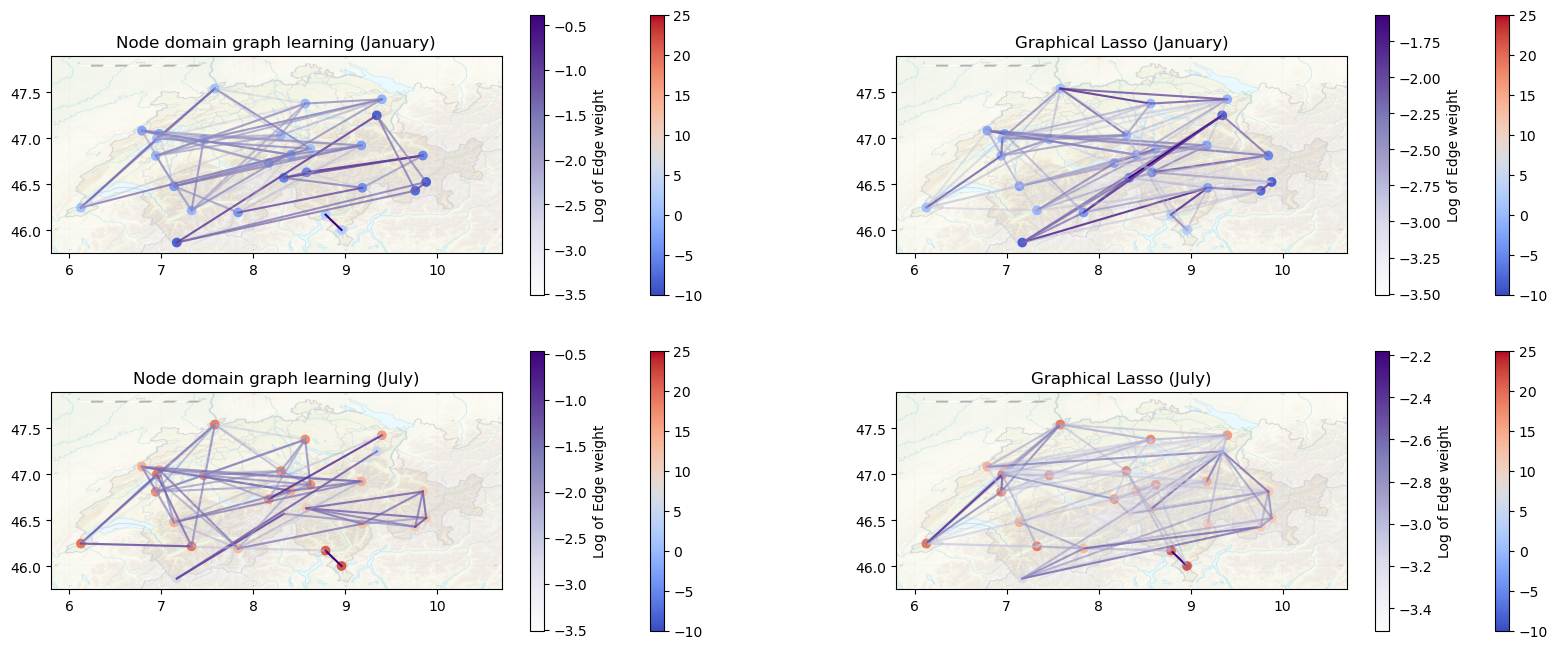

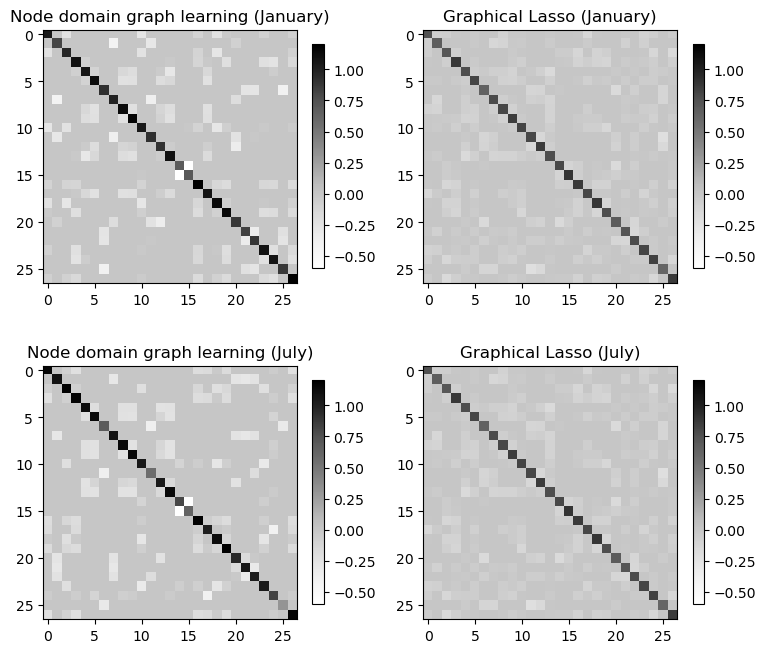

In [20]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(2, 2, 1)
plot_graph(ax1, data_1965_1989_january.mean()["Temperature"], Lap_0_january, N, 0.03, img)
ax1.set_title("Node domain graph learning (January)")

ax2 = plt.subplot(2, 2, 3)
plot_graph(ax2, data_1965_1989_july.mean()["Temperature"], Lap_0_july, N, 0.03, img)
ax2.set_title("Node domain graph learning (July)")

ax3 = plt.subplot(2, 2, 2)
plot_graph(ax3, data_1965_1989_january.mean()["Temperature"], Lap_0_january_lasso, N, 0.03, img)
ax3.set_title("Graphical Lasso (January)")

ax4 = plt.subplot(2, 2, 4)
plot_graph(ax4, data_1965_1989_july.mean()["Temperature"], Lap_0_july_lasso, N, 0.03, img)
ax4.set_title("Graphical Lasso (July)")

plt.show()

plt.figure(figsize=(9, 8))
ax1 = plt.subplot(2, 2, 1)
plt.imshow(Lap_0_january, cmap='Greys', interpolation='nearest', vmin=-0.6, vmax=1.2)
ax1.set_title("Node domain graph learning (January)")
plt.colorbar(shrink=0.8)
ax2 = plt.subplot(2, 2, 2)
plt.imshow(Lap_0_january_lasso, cmap='Greys', interpolation='nearest', vmin=-0.6, vmax=1.2)
ax2.set_title("Graphical Lasso (January)")
plt.colorbar(shrink=0.8)
ax3 = plt.subplot(2, 2, 3)
plt.imshow(Lap_0_july, cmap='Greys', interpolation='nearest', vmin=-0.6, vmax=1.2)
ax3.set_title("Node domain graph learning (July)")
plt.colorbar(shrink=0.8)
ax4 = plt.subplot(2, 2, 4)
plt.imshow(Lap_0_january_lasso, cmap='Greys', interpolation='nearest', vmin=-0.6, vmax=1.2)
ax4.set_title("Graphical Lasso (July)")
plt.colorbar(shrink=0.8)
plt.show()

## Graph Sparsification

C:\Users\Xiaoyang Ma\AppData\Local\Temp\ipykernel_26324\1903616709.py:10: RuntimeWarning: divide by zero encountered in divide
  G = nx.from_numpy_matrix(1 / A)


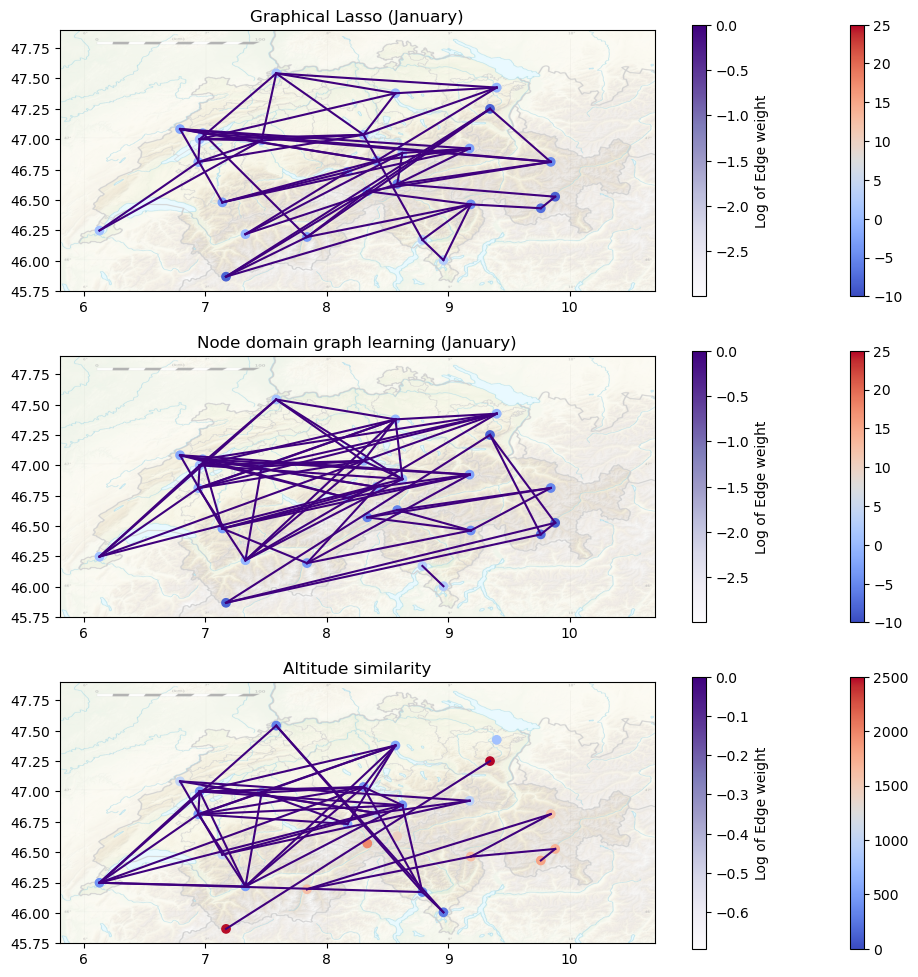

Graphical Lasso F-score: 0.427, NMI: 0.110, Recall: 0.468, Precision: 0.393
Node Domain F-score: 0.589, NMI: 0.252, Recall: 0.702, Precision: 0.508


In [21]:
import networkx as nx
from sklearn.metrics import f1_score, normalized_mutual_info_score, recall_score, precision_score

def graph_sparsify(Lap, th=0.1):
    N = Lap.shape[0]
    Lap_0 = Lap.copy()
    A = -Lap_0
    np.fill_diagonal(A, 0)
    A[A < 1e-10] = 0
    G = nx.from_numpy_matrix(1 / A)
    for i in range(N):
        for j in range(i+1, N):
            d = nx.shortest_path_length(G, i, j, weight="weight")
            p = - Lap_0[i, j] * d
            x = np.random.rand()
            if x > p or A[i, j] < th:
                Lap_0[i, j] = 0
                Lap_0[j, i] = 0
            else:
                Lap_0[i, j] = -1
                Lap_0[j, i] = -1
    return Lap_0

Lap_0_altitude_sparsified = graph_sparsify(Lap_0_altitude, 0.5)
Lap_0_january_sparsified = graph_sparsify(Lap_0_january, 0.05)
Lap_0_january_lasso_sparsified = graph_sparsify(Lap_0_january_lasso, 0.07)

plt.figure(figsize=(12, 12))
ax1 = plt.subplot(3, 1, 1)
plot_graph(ax1, data_1965_1989_january.mean()["Temperature"], Lap_0_january_lasso_sparsified, N, 0.05, img)
ax1.set_title("Graphical Lasso (January)")

ax2 = plt.subplot(3, 1, 2)
plot_graph(ax2, data_1965_1989_january.mean()["Temperature"], Lap_0_january_sparsified, N, 0.05, img)
ax2.set_title("Node domain graph learning (January)")

ax3 = plt.subplot(3, 1, 3)
plot_graph(ax3, altitudes, Lap_0_altitude_sparsified, N, 0.5, img, vmin=0, vmax=2500)
ax3.set_title("Altitude similarity")

plt.show()

def graph_score(Lap, Lap_real, N):
    edge = -Lap[np.triu_indices(N)]
    edge_real = -Lap_real[np.triu_indices(N)]
    return f1_score(edge_real > 0, edge > 0), normalized_mutual_info_score(edge_real > 0, edge > 0), recall_score(edge_real > 0, edge > 0), precision_score(edge_real > 0, edge > 0)

f, nmi, r, p = graph_score(Lap_0_january_lasso_sparsified, Lap_0_altitude_sparsified, N)
print("Graphical Lasso F-score: %.3f, NMI: %.3f, Recall: %.3f, Precision: %.3f" % (f, nmi, r, p))
f, nmi, r, p = graph_score(Lap_0_january_sparsified, Lap_0_altitude_sparsified, N)
print("Node Domain F-score: %.3f, NMI: %.3f, Recall: %.3f, Precision: %.3f" % (f, nmi, r, p))

# f_list = []
# for i in np.logspace(-4,0,20):
#     Lap_0_january_temp = graph_sparsify(Lap_0_january, i)
#     f_list.append(graph_f_score(Lap_0_january_temp, Lap_0_altitude_sparsified, N))
# plt.figure(figsize=(4,4))
# plt.plot(np.logspace(-4,0,20), f_list)
# plt.show()

# Time-Varying Graph Learning

## 1. Graph Filter

                                     CVXPY                                     
                                     v1.2.2                                    
(CVXPY) Dec 13 08:33:55 PM: Your problem has 8019 variables, 11 constraints, and 0 parameters.
(CVXPY) Dec 13 08:33:55 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 13 08:33:55 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 13 08:33:55 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 13 08:33:55 PM: Compiling problem (target solver=ECOS).
(CVXPY) Dec 13 08:33:55 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing

e:\anaconda3\envs\py3.9\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Dec 13 08:33:57 PM: Problem status: optimal
(CVXPY) Dec 13 08:33:57 PM: Optimal value: 9.342e-01
(CVXPY) Dec 13 08:33:57 PM: Compilation took 1.361e-01 seconds
(CVXPY) Dec 13 08:33:57 PM: Solver (including time spent in interface) took 5.225e-01 seconds
                                     CVXPY                                     
                                     v1.2.2                                    
(CVXPY) Dec 13 08:33:57 PM: Your problem has 12 variables, 0 constraints, and 0 parameters.
(CVXPY) Dec 13 08:33:57 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 13 08:33:57 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 13 08:33:57 PM: CVX

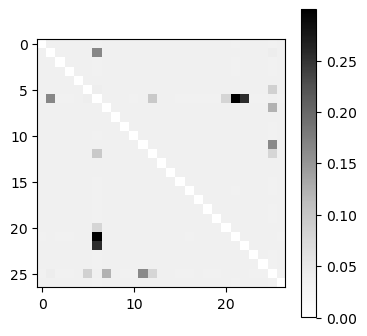

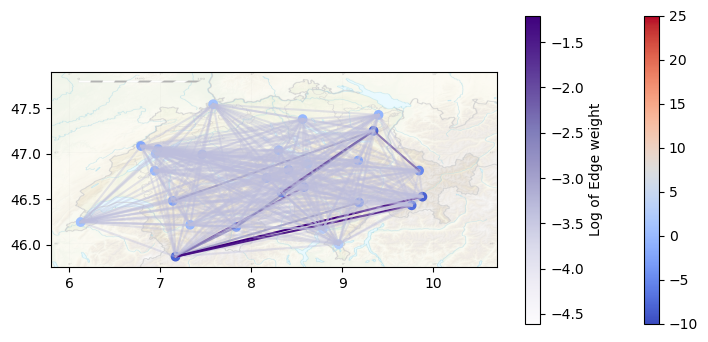

In [8]:
data_1965_1989_time = data_1965_1989.groupby("Station")

data_1965_1989_temp = np.array(
    data_1965_1989_time["Temperature"]
    .apply(lambda x: np.array(x.values.tolist()))
    .values.tolist()
).reshape(
    len(stations), -1, 12
)  # number of stations (27) x number of years (25) x months (12)

def topo_infer_time(data, N, alpha, beta, gamma, k=12):
    # M = k - 1 in the paper, R_list[i] is R_{k-1-i} in the paper
    R_list = [cp.Variable((N, N), symmetric=True) for _ in range(k-1)]
    # constraints = []
    constraints = [R >= 0 for R in R_list] #  + [cp.sum(R) == N for R in R_list]
    objective = cp.Minimize(cp.sum_squares(data[:, :, -1] - cp.sum([R_list[i] @ data[:, :, i] for i in range(k-1)], axis=2)) + alpha * cp.sum([cp.sum(cp.abs(R)) for R in R_list]))
    prob = cp.Problem(objective, constraints)
    prob.solve(verbose=True)
    R_list_0 = [R.value for R in R_list]

    A = cp.Variable((N, N), symmetric=True)
    constraints = [A >= 0, cp.sum(A) >= N, cp.diag(A) == 0]
    # constraints = [A >= 0, cp.diag(A) == 0]
    objective = cp.Minimize(cp.sum_squares(R_list_0[-1] - A) + gamma * cp.sum(A) + beta * cp.sum([cp.sum_squares(A @ R - R @ A) for R in R_list_0[:-1]]))
    prob = cp.Problem(objective, constraints)
    prob.solve(verbose=True)

    A_power_list = [np.linalg.matrix_power(A.value, i) for i in range(k)]

    # C_list[i] is C_{k-1-i} in the paper
    C_list = [cp.Variable(k-i) for i in range(k-1)]
    for i in range(k-1):
        C = C_list[i]
        # constraints = [cp.sum(cp.abs(C)) >= 1]
        constraints = []
        objective = cp.Minimize(cp.sum_squares(R_list_0[i] - cp.sum([C[j] * A_power_list[j] for j in range(k-i)])) + gamma * cp.norm(C, 1))
        prob = cp.Problem(objective, constraints)
        prob.solve(verbose=True)

    return np.array(R_list_0), A.value, [C.value for C in C_list]

R_list, A, C_list = topo_infer_time(data_1965_1989_temp, N, 5, 0.05, 0.001)
print(A)

plt.figure(figsize=(4, 4))
plt.imshow(A, cmap='Greys', interpolation='nearest')
plt.colorbar()
plt.show()

plt.figure(figsize=(9, 4))
ax1 = plt.subplot(1, 1, 1)
plot_graph(ax1, data_1965_1989_january.mean()["Temperature"], -A, N, 0.01, img)

plt.show()


(11, 27, 27)
(27, 25, 12)


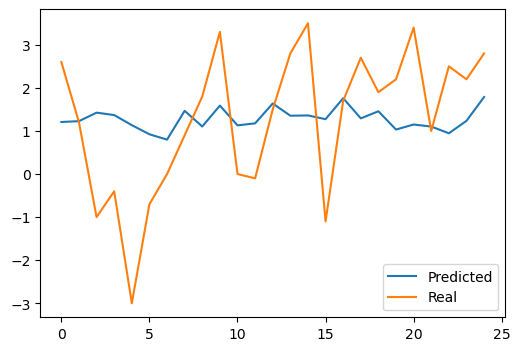

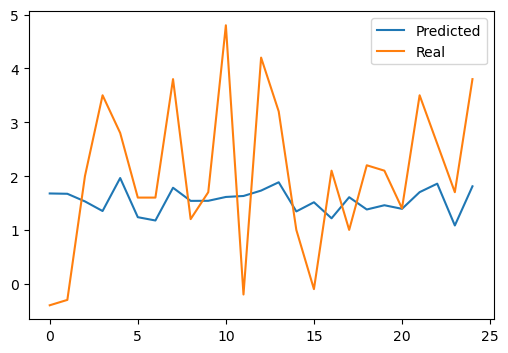

In [9]:
print(R_list.shape)
print(data_1965_1989_temp.shape)
pred = np.einsum("ijk, kmi -> jm", R_list, data_1965_1989_temp[:, :, :-1])
real = data_1965_1989_temp[:, :, -1] # 27x25

plt.figure(figsize=(6, 4))
plt.plot(pred[0, :], label="Predicted")
plt.plot(real[0, :], label="Real")
plt.legend()
plt.show()

data_1990_2014 = df_all[(df_all["Year"] >= 1990) & (df_all["Year"] < 2015)]
data_1990_2014_time = data_1990_2014.groupby("Station")
data_1990_2014_temp = np.array(
    data_1990_2014_time["Temperature"]
    .apply(lambda x: np.array(x.values.tolist()))
    .values.tolist()
).reshape(
    len(stations), -1, 12
)
pred_test = np.einsum("ijk, kmi -> jm", R_list, data_1990_2014_temp[:, :, :-1])
real_test = data_1990_2014_temp[:, :, -1]

plt.figure(figsize=(6, 4))
plt.plot(pred_test[0, :], label="Predicted")
plt.plot(real_test[0, :], label="Real")
plt.legend()
plt.show()

(11, 27, 27)
(27, 25, 11)


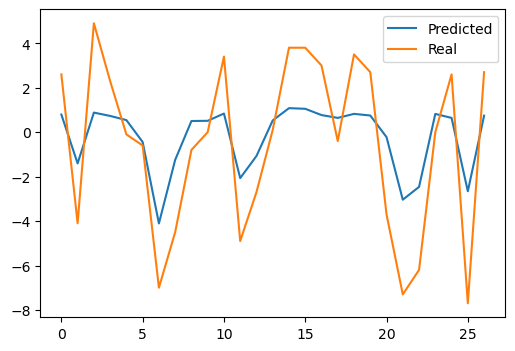

(27, 1)
(27, 25)


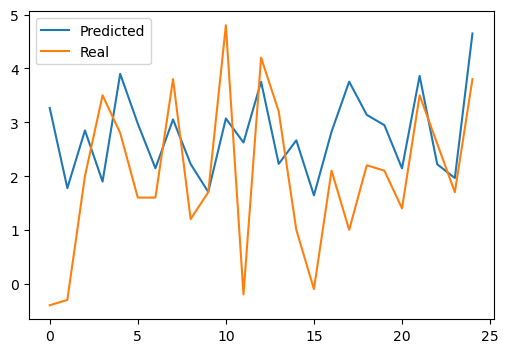

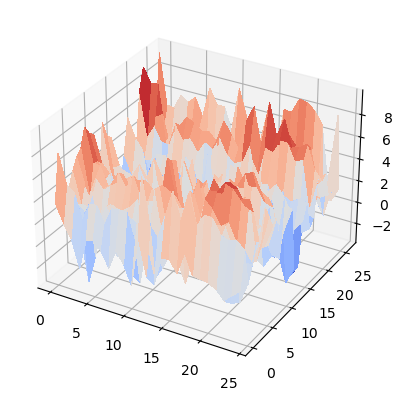

In [10]:
k = 12
A_power_list = [np.linalg.matrix_power(A, i) for i in range(k)]
R_list_A = np.array([np.sum([C_list[i][j] * A_power_list[j] for j in range(k-i)], axis=0) for i in range(k-1)])
print(R_list_A.shape)
print(data_1965_1989_temp[:, :, :-1].shape)

pred_new = np.einsum("ijk, kmi -> jm", R_list_A, data_1965_1989_temp[:, :, :-1])

plt.figure(figsize=(6, 4))
plt.plot(pred_new[:, 0], label="Predicted")
plt.plot(real[:, 0], label="Real")
plt.legend()
plt.show()

b = np.mean(real - pred_new, axis=1).reshape(-1, 1)
print(b.shape)
b = np.zeros((N, 1))

pred_test_new = np.einsum("ijk, kmi -> jm", R_list_A, data_1990_2014_temp[:, :, :-1]) + b
print(pred_test_new.shape)

plt.figure(figsize=(6, 4))
plt.plot(pred_test_new[0, :], label="Predicted")
plt.plot(real_test[0, :], label="Real")
plt.legend()
plt.show()

# Plot 3D error
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X, Y = np.meshgrid(np.arange(0, 25), np.arange(0, N))
ax.plot_surface(X, Y, pred_test_new - real_test, cmap=cm.coolwarm, linewidth=0, antialiased=False)
plt.show()

## 2. Time-Varying Graphical Lasso with GFT

In [11]:
def topo_infer_time_glasso(data, N, l, beta, k=12):
    # data: N(Stations) x M(Years) x k
    # print(data.shape)
    M = data.shape[1] if data.ndim >= 2 else 1
    if M == 1:
        data = data.reshape(-1, 1)
    S = [np.cov(data[:, :, i]) for i in range(k)]

    Q_list = [cp.Variable((N, N), PSD=True) for _ in range(k)]
    objective = cp.Minimize(cp.sum([-cp.log_det(Q_list[i]) + cp.trace(S[i] @ Q_list[i]) + l * cp.sum(cp.abs(Q_list[i])) for i in range(k)]) + beta * cp.sum([cp.sum_squares(Q_list[i+1] - Q_list[i]) for i in range(k-1)]))# beta * cp.sum([cp.sum(cp.abs(Q_list[i+1] - Q_list[i])) for i in range(k-1)]))
    prob = cp.Problem(objective)
    prob.solve(verbose=True)

    # Linear regression for spectral coefficients
    X = np.zeros((N, M, k))

    for i in range(k):
        [_, U] = np.linalg.eigh(Q_list[i].value)
        X[:, :, i] = U.T @ data[:, :, i]
    
    a = X[:, :, :-1]
    y = X[:, :, -1]

    coef = np.zeros((N, k))

    for i in range(N):
        coef_i, _, _, _ = np.linalg.lstsq(np.c_[a[i, :, :], np.ones(M)], y[i, :])

        # Print the model coefficients
        # print(np.linalg.norm(a[i, :, :] @ coef_i[:-1] + coef_i[-1] - y[i, :]))
        coef[i, :] = coef_i

    return np.array([Q.value for Q in Q_list]), coef

# def GFT(Lap, x):
#     [U, _] = np.linalg.eigh(Lap)
#     return U.T @ x

# def GFT_inv(Lap, x):
#     [U, _] = np.linalg.eigh(Lap)
#     return U @ x

Q_list, lin_coef = topo_infer_time_glasso(data_1965_1989_temp, N, 0.5, 0.05, 12)
print(Q_list)


                                     CVXPY                                     
                                     v1.2.2                                    
(CVXPY) Dec 13 08:33:59 PM: Your problem has 8748 variables, 0 constraints, and 0 parameters.
(CVXPY) Dec 13 08:33:59 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 13 08:33:59 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 13 08:33:59 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 13 08:33:59 PM: Compiling problem (target solver=SCS).
(CVXPY) Dec 13 08:33:59 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -

C:\Users\Xiaoyang Ma\AppData\Local\Temp\ipykernel_26324\4138601791.py:27: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_i, _, _, _ = np.linalg.lstsq(np.c_[a[i, :, :], np.ones(M)], y[i, :])


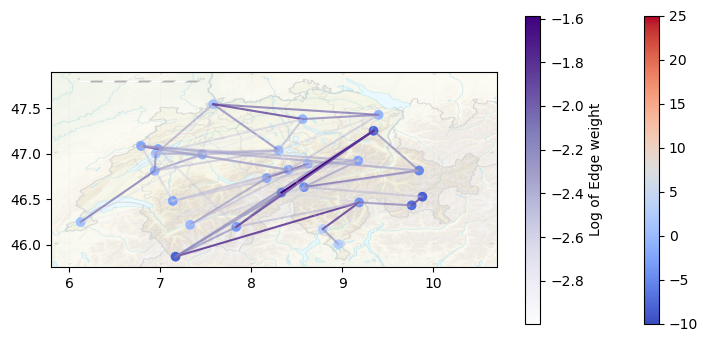

In [12]:
plt.figure(figsize=(9, 4))
ax1 = plt.subplot(1, 1, 1)
plot_graph(ax1, data_1965_1989_january.mean()["Temperature"], Q_list[0], N, 0.05, img)
plt.show()

## 3. Time-Varying Node Domain Technique with GFT

In [13]:
def topo_infer_time_node(data, N, alpha, beta, gamma, iter=20, k=12):
    # data: N(Stations) x M(Years) x k
    # print(data.shape)
    M = data.shape[1] if data.ndim >= 2 else 1
    if M == 1:
        data = data.reshape(-1, 1)
    
    y_list = [cp.Variable((N, M)) for _ in range(k)]
    y_0 = [data[:, :, i] for i in range(k)]
    Lap_list = [cp.Variable((N, N), PSD=True) for _ in range(k)]

    for cnt in range(iter):
        print(cnt)
        constraints = [Lap @ np.ones((N,)) == np.zeros((N,)) for Lap in Lap_list] + [Lap - cp.diag(cp.diag(Lap)) <= 0 for Lap in Lap_list]
        objective = cp.Minimize(alpha * cp.sum([cp.trace(cp.quad_form(y_0[i], Lap_list[i])) for i in range(k)]) + beta * cp.sum([cp.norm(Lap, "fro") ** 2 for Lap in Lap_list]) + gamma * cp.sum([cp.sum_squares(Lap_list[i+1] - Lap_list[i]) for i in range(k-1)]))
        prob = cp.Problem(objective, constraints)
        prob.solve()
        Lap_0 = [Lap.value for Lap in Lap_list]
        Lap_0 = [Lap - np.eye(N) * np.min(np.linalg.eigvals(Lap)) for Lap in Lap_0]
        objective2 = cp.Minimize(cp.sum([cp.norm(y_list[i] - data[:, :, i], "fro") ** 2 for i in range(k)]) + alpha * cp.sum([cp.sum([cp.quad_form(y_list[j][:, i], Lap_0[j]) for i in range(M)]) for j in range(k)]))
        prob2 = cp.Problem(objective2)
        prob2.solve()
        y_0 = [y.value for y in y_list]

    # Linear regression for spectral coefficients
    X = np.zeros((N, M, k))

    for i in range(k):
        [_, U] = np.linalg.eigh(Lap_list[i].value)
        X[:, :, i] = U.T @ data[:, :, i]
    
    a = X[:, :, :-1]
    b = X[:, :, -1]

    coef = np.zeros((N, k))

    for i in range(N):
        coef_i, _, _, _ = np.linalg.lstsq(np.c_[a[i, :, :], np.ones(M)], b[i, :])

        # Print the model coefficients
        # print(np.linalg.norm(a[i, :, :] @ coef_i[:-1] + coef_i[-1] - y[i, :]))
        coef[i, :] = coef_i

    return np.array([Lap.value for Lap in Lap_list]), coef

Lap_list, lin_coef_node = topo_infer_time_node(data_1965_1989_temp, N, 0.02, 0.5, 0.05, 20)


0


e:\anaconda3\envs\py3.9\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


C:\Users\Xiaoyang Ma\AppData\Local\Temp\ipykernel_26324\3737288321.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_i, _, _, _ = np.linalg.lstsq(np.c_[a[i, :, :], np.ones(M)], b[i, :])


(27, 25)
(27, 25)


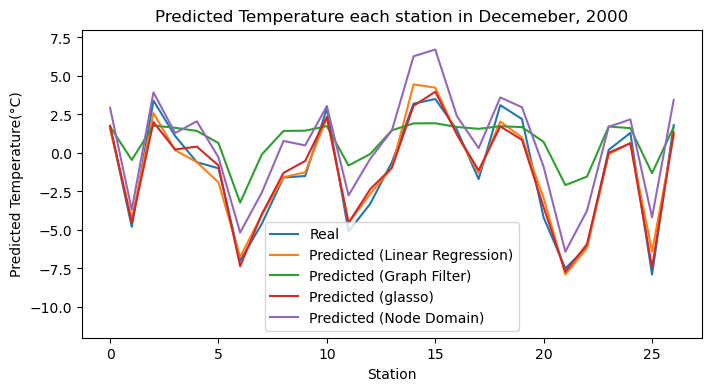

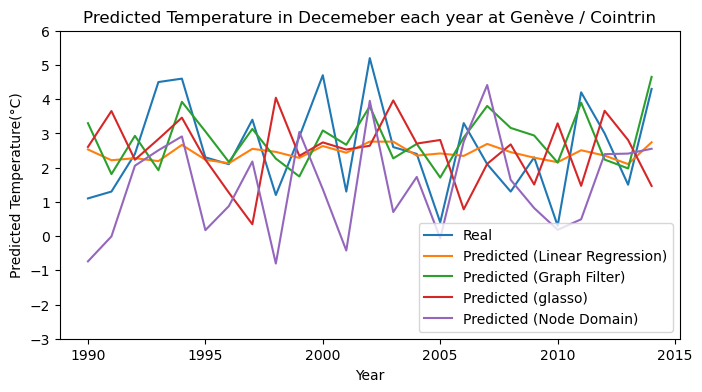

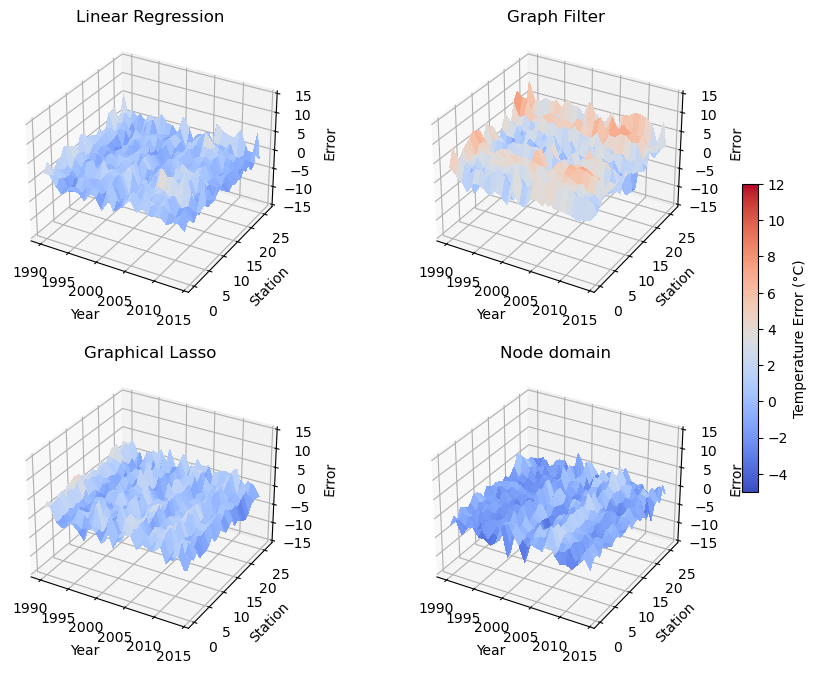

3.193204469448633
13.986064281939724
4.3209852855436095
4.675356995967753


In [14]:
def pred_topo_infer_time_glasso(data, Q_list, lin_coef, N, k=12):
    # data: N(Stations) x M(Years) x k
    # Q_list: k x N x N
    # lin_coef: N x k
    M = data.shape[1] if data.ndim >= 2 else 1
    if M == 1:
        data = data.reshape(-1, 1)
    
    # Compute spectral coefficients
    X = np.zeros((N, M, k-1)) # spectral coefficients

    for i in range(k-1):
        [_, U] = np.linalg.eigh(Q_list[i, :, :])
        X[:, :, i] = U.T @ data[:, :, i]
    
    # Compute spectral coefficients for last month
    X_last = np.einsum("nmk, nkl -> nml", X, lin_coef[:, :-1, np.newaxis])[:,:,0] + lin_coef[:, [-1]]
    
    # Compute prediction
    [_, U] = np.linalg.eigh(Q_list[-1, :, :])

    return U @ X_last

pred_test_glasso = pred_topo_infer_time_glasso(data_1990_2014_temp[:, :, :-1], Q_list, lin_coef, N)
pred_test_node = pred_topo_infer_time_glasso(data_1990_2014_temp[:, :, :-1], Lap_list, lin_coef_node, N)

print(pred_test_glasso.shape)
print(pred_test_node.shape)

# plt.figure(figsize=(6, 4))
# plt.plot(pred_test_glasso[:, 10], label="Predicted")
# plt.plot(real_test[:, 10], label="Real")
# plt.legend()
# plt.show()

# plt.figure(figsize=(6, 4))
# plt.plot(pred_test_glasso[0, :], label="Predicted")
# plt.plot(real_test[0, :], label="Real")
# plt.legend()
# plt.show()

plt.figure(figsize=(8, 4))
plt.plot(real_test[:, 9], label="Real")
plt.plot(pred_test[:, 9], label="Predicted (Linear Regression)")
plt.plot(pred_test_new[:, 9], label="Predicted (Graph Filter)")
plt.plot(pred_test_glasso[:, 9], label="Predicted (glasso)")
plt.plot(pred_test_node[:, 9], label="Predicted (Node Domain)")
plt.legend()
plt.xlabel("Station")
plt.ylabel("Predicted Temperature(°C)")
plt.title("Predicted Temperature each station in Decemeber, 2000")
plt.ylim([-12, 8])
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(1990+np.arange(0, 25), real_test[10, :], label="Real")
plt.plot(1990+np.arange(0, 25), pred_test[10, :], label="Predicted (Linear Regression)")
plt.plot(1990+np.arange(0, 25), pred_test_new[10, :], label="Predicted (Graph Filter)")
plt.plot(1990+np.arange(0, 25), pred_test_glasso[10, :], label="Predicted (glasso)")
plt.plot(1990+np.arange(0, 25), pred_test_node[10, :], label="Predicted (Node Domain)")
plt.legend(loc='lower right')
plt.xlabel("Year")
plt.ylabel("Predicted Temperature(°C)")
plt.title("Predicted Temperature in Decemeber each year at Genève / Cointrin")
plt.ylim([-3, 6])
plt.show()

# Plot 3D error
fig = plt.figure(figsize=(12, 8))

ax1 = fig.add_subplot(2, 2, 1, projection='3d')
X, Y = np.meshgrid(np.arange(0, 25) + 1990, np.arange(0, N))
surf = ax1.plot_surface(X, Y, pred_test - real_test, cmap=cm.coolwarm, linewidth=0, antialiased=False, vmin=-5, vmax=12)
ax1.set_zlim(-15, 15)
ax1.set_xlabel("Year")
ax1.set_ylabel("Station")
ax1.set_zlabel("Error")
ax1.set_title("Linear Regression")

ax2 = fig.add_subplot(2, 2, 2, projection='3d')
surf = ax2.plot_surface(X, Y, pred_test_new - real_test, cmap=cm.coolwarm, linewidth=0, antialiased=False, vmin=-5, vmax=12)
ax2.set_zlim(-15, 15)
ax2.set_xlabel("Year")
ax2.set_ylabel("Station")
ax2.set_zlabel("Error")
ax2.set_title("Graph Filter")

ax3 = fig.add_subplot(2, 2, 3, projection='3d')
surf = ax3.plot_surface(X, Y, pred_test_glasso - real_test, cmap=cm.coolwarm, linewidth=0, antialiased=False, vmin=-5, vmax=12)
ax3.set_zlim(-15, 15)
ax3.set_xlabel("Year")
ax3.set_ylabel("Station")
ax3.set_zlabel("Error")
ax3.set_title("Graphical Lasso")

ax4 = fig.add_subplot(2, 2, 4, projection='3d')
surf = ax4.plot_surface(X, Y, pred_test_node - real_test, cmap=cm.coolwarm, linewidth=0, antialiased=False, vmin=-5, vmax=12)
ax4.set_zlim(-15, 15)
ax4.set_xlabel("Year")
ax4.set_ylabel("Station")
ax4.set_zlabel("Error")
ax4.set_title("Node domain")

cbar = plt.colorbar(surf, ax=[ax1, ax2, ax3, ax4], shrink=0.5)
cbar.set_label("Temperature Error (°C)")

plt.show()

print(np.linalg.norm(pred_test - real_test) ** 2 / (N * 25))
print(np.linalg.norm(pred_test_new - real_test) ** 2 / (N * 25))
print(np.linalg.norm(pred_test_glasso - real_test) ** 2 / (N * 25))
print(np.linalg.norm(pred_test_node - real_test) ** 2 / (N * 25))
